<a href="https://colab.research.google.com/github/rickiepark/knou_deep_learning/blob/main/02-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[1] 필요한 패키지 불러오기

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris

[2] 데이터 준비 함수 정의하기

In [2]:
def prepare_data(target):
    iris = load_iris()          # iris data set 읽기
    X_tr = iris.data[:, 2:]     # 4개의 특징 중 꽃잎의 길이와 폭 선택
    labels = iris.target_names  # 'setosa', 'versicolor', 'virginica'
    y = iris.target
    
    # 학습표본의 레이블 지정 - target에 지정된 레이블이면 1, 그 외는 0
    target_lable = np.where(labels == target)[0]
    y_tr = (y == target_lable).astype(int)
    return X_tr, y_tr, ['(1) '+target, '(0) the others']

[3] 활성함수 - 시그모이드

In [3]:
from scipy.special import expit


def sigmoid(x):
    ''' x : numpy array '''
    return expit(x)

[4] 손실함수 - mse, cross entropy

In [4]:
def loss_mse(y, y_hat):
    loss = np.sum((y_hat - y) ** 2)
    return loss / len(y)

def loss_ce(y, y_hat):
    if len(y.shape) == 1 or y.shape[1] == 1:
        loss = np.sum(-(y * np.log(y_hat) + 
                        (1 - y) * np.log((1 - y_hat))))
    else:
        loss = np.sum(-(y * np.log(y_hat)))
    return loss / len(y)

[5] Dense 클래스 - 완전연결층

In [5]:
class Dense():
    def __init__(self, n_in, n_out, activation='sigmoid', loss='mse'):
        self.n_in = n_in          # 입력의 수
        self.n_out = n_out        # 출력의 수
        # 가중치(w)와 바이어스(b)를 He normal 방식으로 초기화
        rnd = np.random.default_rng()
        self.w = rnd.normal(scale = np.sqrt(2.0 / self.n_in),
                            size = (self.n_out, self.n_in))
        self.b = rnd.normal(scale = np.sqrt(2.0 / self.n_in),
                            size = self.n_out)
        # 활성함수 설정
        if activation == 'sigmoid':
            self.activation = sigmoid
            if loss == 'ce':
                self.dE_du = self.dE_du_sigmoid_ce
            else:
                self.dE_du = self.dE_du_sigmoid_mse
            self.do_du = self.do_du_sigmoid
        # 모멘텀을 적용하기 위한 속도의 초깃값 설정
        self.velocity_w, self.velocity_b = 0.0, 0.0
    
    # 입력 X에 대한 출력 계산
    def output(self, X):
        self.in_vec = X     # bp 학습을 위해 입력 보관
        # 입력의 가중 합 계산
        u = np.dot(self.w, X) + self.b
        # 활성함수를 적용한 출력 계산
        self.out_vec = self.activation(u)  # bp 학습을 위해 출력 보관
        return self.out_vec
    
    # 경사 하강법에 따라 w 및 b 갱신
    def gd(self, dw, db, momentum=0):
        self.velocity_w = self.velocity_w * momentum - dw
        self.velocity_b = self.velocity_b * momentum - db
        self.w += self.velocity_w
        self.b += self.velocity_b

    def dE_du_sigmoid_mse(self, y):
        return (self.out_vec - y) * self.do_du_sigmoid()

    def dE_du_sigmoid_ce(self, y):
        return self.out_vec - y

    def do_du_sigmoid(self):
        return self.out_vec * (1 - self.out_vec)

[6] BP_Model : BP 학습을 하는 피드포워드 모델 클래스

In [6]:
class BP_Model():
    def __init__(self, n_unit_lst, loss='mse',
                 activation_h='sigmoid', activation_o='sigmoid'):
        layers = []
        self.n_layers = len(n_unit_lst) - 1
        # 은닉층 구성
        for i in range(self.n_layers - 1):
            layers.append(Dense(n_unit_lst[i], n_unit_lst[i+1],
                                activation=activation_h, loss=loss))
        # 출력층 구성
        layers.append(Dense(n_unit_lst[self.n_layers-1],
                            n_unit_lst[self.n_layers], activation=activation_o, 
                            loss=loss))
        self.layers = np.array(layers, dtype=object)
        self.ohe = np.identity(n_unit_lst[-1])
        if loss == 'ce':
            self.loss = loss_ce
        else:
            self.loss = loss_mse
    
    def predict(self, x):
        res = []
        for j in range(len(x)):
            xx = x[j]
            for i in range(self.n_layers):
                xx = self.layers[i].output(xx)
            res.append(xx)
        return np.array(res)
    
    def fit(self, X, y, N, epochs, eta=0.01, momentum=0):
        # 학습표본의 인덱스를 무작위 순서로 섞음
        random_idx = np.random.permutation(N)
        X = X[random_idx]
        y = y[random_idx].reshape(-1,1)
        if self.layers[self.n_layers-1].n_out != 1:
            y = self.ohe[y]

        # w와 b의 변화량을 저장할 수 있게 준비함
        dw, db = [], []
        for i in range(self.n_layers):
            dw.append(np.zeros((self.layers[i].n_out,
                                self.layers[i].n_in)))
            db.append(np.zeros(self.layers[i].n_out))
        for n in range(epochs):
            for m in range(N):
                # output layer
                lyr_idx = self.n_layers - 1
                curr_layer = self.layers[lyr_idx]
                self.predict([X[m]])
                delta = curr_layer.dE_du(y[m])
                du_dw = curr_layer.in_vec
                for j in range(curr_layer.n_out):
                    dw[lyr_idx][j] = eta * delta[j] * du_dw
                    db[lyr_idx][j] = eta * delta[j]
                next_delta = delta
                next_layer = curr_layer
                
                # hidden layers
                for lyr_idx in range(self.n_layers-2, -1, -1):
                    curr_layer = self.layers[lyr_idx]
                    dE_do = []
                    for n_o in range(curr_layer.n_out):
                        delta_w = next_delta * next_layer.w[:, n_o]
                        dE_do.append(delta_w.sum())
                    delta = dE_do  * curr_layer.do_du()
                    du_dw = curr_layer.in_vec
                    for j in range(curr_layer.n_out):
                        dw[lyr_idx][j] = eta * delta[j] * du_dw
                        db[lyr_idx][j] = eta * delta[j]
                    next_delta = delta
                    next_layer = curr_layer

                for i in range(self.n_layers):
                    self.layers[i].gd(dw[i], db[i], momentum)

            # 학습 과정 출력
            if n < 10 or (n+1) % 100 == 0:
                y_hat = self.predict(X)
                print('에포크 = {:4d}   손실 = {:8.5f}'.format(
                    n+1, self.loss(y, y_hat)))

[7] BP 모델의 분류 결과 시각화

In [7]:
def visualize(net, X, y, multi_class, labels, class_id, colors, 
               xlabel, ylabel, legend_loc='lower right'):
    # 데이터의 최소~최대 범위를 0.05 간격의 좌표값으로 나열
    x1_max = np.max(X[:, 0]) + 0.5
    x1_min = np.min(X[:, 0]) - 0.5
    x2_max = np.max(X[:, 1]) + 0.5
    x2_min = np.min(X[:, 1]) - 0.5
    x1_lin = np.linspace(x1_min, x1_max, 200)
    x2_lin = np.linspace(x2_min, x2_max, 200)
    
    # x_lin과 y_lin의 격자좌표의 x와 y 값 구하기
    x1_mesh, x2_mesh = np.meshgrid(x1_lin, x2_lin)
    
    # (x, y) 좌표의 배열로 만들어 신경망의 입력 구성
    X_test = np.column_stack([x1_mesh.ravel(), x2_mesh.ravel()])
    
    # 학습된 신경망으로 X_test에 대한 출력 계산
    if multi_class:
        y_hat = np.argmax(net.predict(X_test), axis=1)
    else:
        y_hat = (net.predict(X_test) >= 0.5).astype(int)
    y_hat = y_hat.reshape(-1)
    
    # 출력할 그래프의 수평/수직 범위 설정
    plt.xlim(x1_min, x1_max)
    plt.ylim(x2_min, x2_max)
    
    # 클래스별로 산점도 그리기
    for c, i, c_name in zip (colors, labels, class_id):
        # 격자 좌표의 클래스별 산점도
        plt.scatter(X_test[y_hat == i, 0], X_test[y_hat == i, 1],
                    c=c, s=5, alpha=0.1, edgecolors='none')
        # 학습 표본의 클래스별 산점도
        plt.scatter(X[y==i, 0], X[y==i, 1],
                    c=c, s=20, label=c_name)
    # 범례의 표시 위치 지정
    plt.legend(loc=legend_loc)
    # x축과 y축의 레이블을 지정한 후 그래프 출력
    plt.xlabel(xlabel, size=12)
    plt.ylabel(ylabel, size=12)
    plt.show()

[8] 훈련 데이터 준비하기

In [8]:
n_samples = 150
n_dim = 2
target = 'versicolor'         # 식별하고자 하는 붓꽃 종류 지정
X_tr, y_tr, labels = prepare_data(target)

[9] BP_Model 객체 생성 및 학습

In [9]:
bp_iris = BP_Model([n_dim, 4, 1], loss='mse',
                   activation_h='sigmoid', activation_o='sigmoid')
bp_iris.fit(X_tr, y_tr, n_samples, epochs=1000, eta=0.1, momentum=0.9)

에포크 =    1   손실 =  0.22315
에포크 =    2   손실 =  0.21487
에포크 =    3   손실 =  0.20483
에포크 =    4   손실 =  0.19472
에포크 =    5   손실 =  0.18627
에포크 =    6   손실 =  0.18069
에포크 =    7   손실 =  0.17741
에포크 =    8   손실 =  0.17547
에포크 =    9   손실 =  0.17422
에포크 =   10   손실 =  0.17337
에포크 =  100   손실 =  0.03267
에포크 =  200   손실 =  0.03732
에포크 =  300   손실 =  0.03555
에포크 =  400   손실 =  0.04909
에포크 =  500   손실 =  0.04866
에포크 =  600   손실 =  0.03319
에포크 =  700   손실 =  0.03273
에포크 =  800   손실 =  0.03402
에포크 =  900   손실 =  0.03300
에포크 = 1000   손실 =  0.03358


[10] 특징 공간 결정 영역 시각화

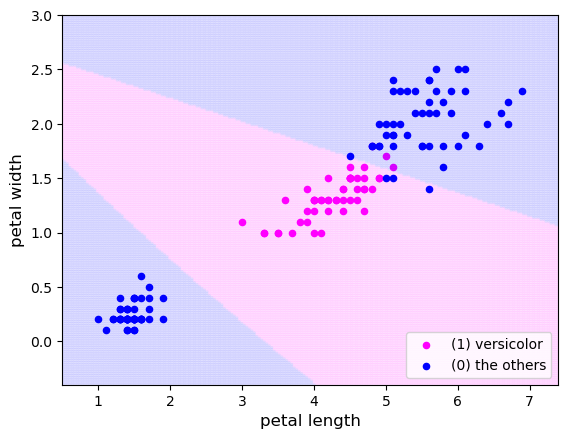

In [10]:
visualize(bp_iris, X_tr, y_tr,
          multi_class=False,
          class_id=labels,
          labels=[1, 0],
          colors=['magenta', 'blue'],
          xlabel='petal length',
          ylabel='petal width')